In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Parameters Vector

Load and normalization vector of parameters.

In [176]:
# Loading csv file with parameters
allpatients = pd.read_csv('Dataset/female_a_1.csv')
allpatients.head()

,MAX,MIN,RMS,KURTOSIS,SKEWNESS,Status
0,18760.0,-11958.0,5294.547930,0.317484,0.894478,Chory
1,7822.0,-9809.0,3423.929549,-0.643199,-0.277961,Chory
2,8645.0,-12309.0,3791.464376,-0.876762,-0.070322,Chory
3,7948.0,-13705.0,3430.957024,-0.716686,-0.419052,Chory
4,19539.0,-17650.0,4096.550818,0.617535,0.500717,Chory


In [177]:
#Features has diffrent range, so they have to be normalized.
features = allpatients.drop(labels='Status', axis=1).columns
for i in features:
    allpatients[i] = (allpatients[i] - np.mean(allpatients[i]))/np.std(allpatients[i])
allpatients.head()

,MAX,MIN,RMS,KURTOSIS,SKEWNESS,Status
0,0.392833,0.650963,-0.147024,0.270322,1.307170,Chory
1,-1.637035,0.990899,-1.229182,-0.782410,-1.406034,Chory
2,-1.484303,0.595441,-1.016562,-1.038352,-0.925525,Chory
3,-1.613652,0.374617,-1.225117,-0.862938,-1.732540,Chory
4,0.537400,-0.249415,-0.840069,0.599122,0.395947,Chory


# Dummy variables

We'll need to convert categorical features (Status) to dummy variables, because our alghoritm can't understant what means 'healthy'.

In [182]:
status = pd.get_dummies(allpatients['Status'],drop_first=True)

In [183]:
allpatients.drop(['Status'],axis=1,inplace=True)

In [184]:
allpatients['Chory'] = status
allpatients.head()

,MAX,MIN,RMS,KURTOSIS,SKEWNESS,Chory
0,0.392833,0.650963,-0.147024,0.270322,1.307170,0
1,-1.637035,0.990899,-1.229182,-0.782410,-1.406034,0
2,-1.484303,0.595441,-1.016562,-1.038352,-0.925525,0
3,-1.613652,0.374617,-1.225117,-0.862938,-1.732540,0
4,0.537400,-0.249415,-0.840069,0.599122,0.395947,0


# Train test split
Dataset is splitted into train set 75% and test set 25%.

In [185]:
from sklearn.model_selection import train_test_split

In [186]:
X_train, X_test, y_train, y_test = train_test_split(allpatients.drop(['Chory'],axis=1), 
                                                    allpatients['Chory'], 
                                                    test_size=0.25, 
                                                    random_state=42)

### K-fold validation
In order to find best hiper-parameters k-fold validation is used, due to low number of train examples

In [187]:
num_folds = 5

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# Logistic Regression

In [188]:
from sklearn.linear_model import LogisticRegression

In [189]:
accuracies = {}
C = [1e-2, 1e-1, 5e-1, 1, 1.4, 1.8, 2, 2.4, 2.8, 3, 5, 10]

for c in C:
    for i in range(num_folds):
        logModel = LogisticRegression(penalty='l1', C=c, solver='liblinear')
        
        train_set = np.concatenate(X_train_folds[:i]+X_train_folds[i+1:])
        labels_set = np.concatenate(y_train_folds[:i]+y_train_folds[i+1:])
        
        logModel.fit(train_set, labels_set) 
        
        y_val_pred = logModel.predict(X_train_folds[i])
        val_acc = np.mean(y_val_pred == y_train_folds[i])
        
        if c in accuracies:
            accuracies[c].extend([val_acc])
        else:
            accuracies[c] = [val_acc]

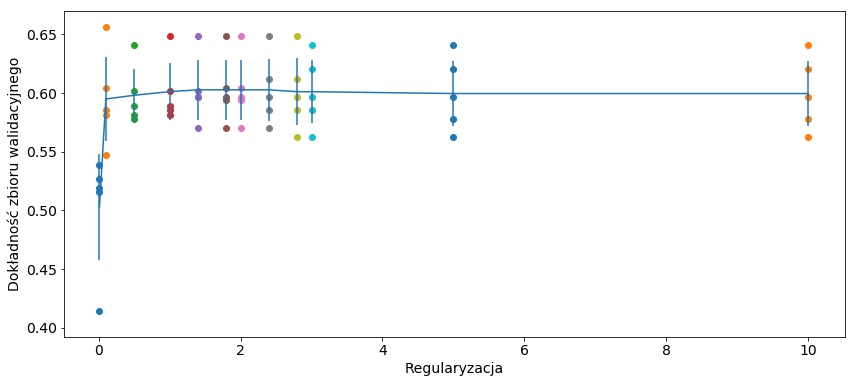

In [190]:
# plot the raw observations

for c in C:
    acc = accuracies[c]
    plt.scatter([c] * len(acc), acc)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(accuracies.items())])
plt.errorbar(C, accuracies_mean, yerr=accuracies_std)
plt.xlabel('Regularyzacja', fontsize=14)
plt.ylabel('Dokładność zbioru walidacyjnego', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [191]:
# Based on the cross-validation results above  I picked optimal C.
# I retrain the classifier using all the training data, and test it on the test
# data.
c = 2
log_model = LogisticRegression(penalty='l1', C=c, solver='liblinear')
log_model.fit(X_train, y_train)
prediction = log_model.predict(X_test)

# Evaluation
Check precission, recall, f1-score using classification report

In [192]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.56      0.69      0.62       105
           1       0.61      0.48      0.54       109

   micro avg       0.58      0.58      0.58       214
   macro avg       0.58      0.58      0.58       214
weighted avg       0.59      0.58      0.57       214



In [193]:
print(confusion_matrix(y_test,prediction))

[[72 33]
 [57 52]]


# Random Forest

In [194]:
from sklearn.ensemble import RandomForestClassifier

In [195]:
accuracies = {}
n_estimators = [10, 50, 100, 120, 140, 160, 180, 200, 250, 300]

for n in n_estimators:
    for i in range(num_folds):
        rf_model = RandomForestClassifier(n_estimators=n)
        
        train_set = np.concatenate(X_train_folds[:i]+X_train_folds[i+1:])
        labels_set = np.concatenate(y_train_folds[:i]+y_train_folds[i+1:])
        
        rf_model.fit(train_set, labels_set) 
        
        y_val_pred = rf_model.predict(X_train_folds[i])
        val_acc = np.mean(y_val_pred == y_train_folds[i])
        
        if n in accuracies:
            accuracies[n].extend([val_acc])
        else:
            accuracies[n] = [val_acc]

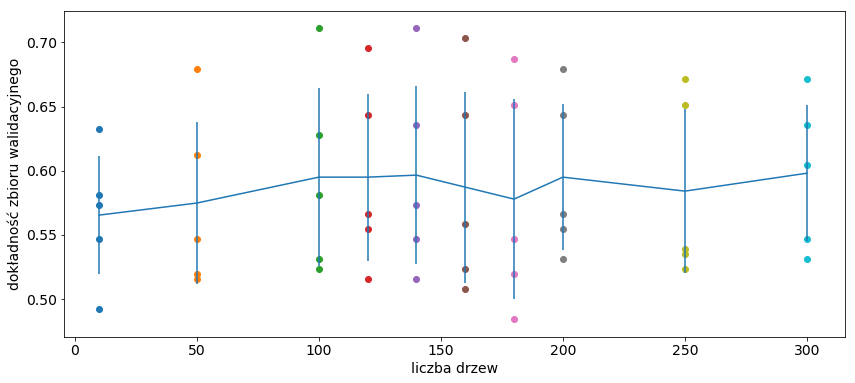

In [196]:
# plot the raw observations

for n in n_estimators:
    acc = accuracies[n]
    plt.scatter([n] * len(acc), acc)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(accuracies.items())])
plt.errorbar(n_estimators, accuracies_mean, yerr=accuracies_std)
plt.xlabel('liczba drzew', fontsize=14)
plt.ylabel('dokładność zbioru walidacyjnego', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [197]:
# Based on the cross-validation results above  I picked optimal number of estimators.
# I retrain the classifier using all the training data, and test it on the test
# data.
best_n = 140
rf_model = RandomForestClassifier(n_estimators=best_n)
rf_model.fit(X_train, y_train)
prediction = rf_model.predict(X_test)

# Evaluation

In [198]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.59      0.61      0.60       105
           1       0.61      0.59      0.60       109

   micro avg       0.60      0.60      0.60       214
   macro avg       0.60      0.60      0.60       214
weighted avg       0.60      0.60      0.60       214



In [173]:
print(confusion_matrix(y_test, prediction))

[[35 32]
 [20 43]]


In [174]:
feature_importance = rf_model.feature_importances_

[Text(0,0,'Maks'),
 Text(0,0,'Min'),
 Text(0,0,'RMS'),
 Text(0,0,'Kurt'),
 Text(0,0,'Skos')]

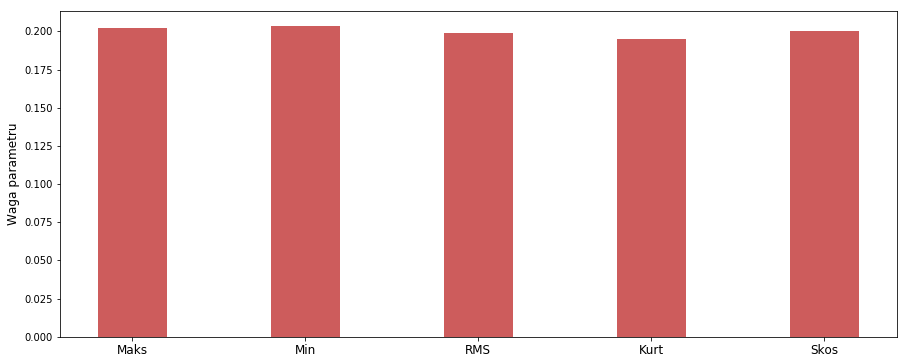

In [175]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
plt.grid(b=False)
ind = np.arange(len(feature_importance))  # the x locations for the groups
width = 0.4  # the width of the bars
ax.bar(ind, feature_importance, width, color='IndianRed')
ax.set_ylabel('Waga parametru', fontsize=12)
ax.set_xticks(ind)
ax.set_xticklabels(['Maks', 'Min', 'RMS', 'Kurt', 'Skos'], fontsize=12)